In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [7]:
# Parámetros de la simulación
num_samples = 1000          # Número de muestras por sigma
signal_length = 1024        # Longitud de la señal
fs = 1.0                    # Frecuencia de muestreo
X_t = np.sin(np.linspace(0, 2 * np.pi, signal_length))  # Señal base
epochs = 10                 # Número de epochs para entrenamiento
learning_rate = 0.001       # Tasa de aprendizaje
test_size = 0.2             # Proporción del conjunto de prueba
batch_size = 32             # Tamaño del batch
sigmas = np.logspace(-1, 1.5, 15)  # Niveles de ruido


In [8]:
def calculate_metrics(y_true, y_pred):
    """
    Calcula MSE, RMSE y MAE entre y_true y y_pred.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae


In [9]:
class MetricsCallback(Callback):
    """
    Callback personalizado para capturar métricas cada 10 epochs.
    """
    def __init__(self, validation_data, noise_level, interval=10):
        super().__init__()
        self.validation_data = validation_data
        self.noise_level = noise_level
        self.interval = interval
        self.history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'mse': [], 'mae': [], 'rmse': []}
    
    def on_epoch_end(self, epoch, logs=None):
        # Guardar métricas cada 'interval' epochs
        if (epoch + 1) % self.interval == 0 or (epoch + 1) == epochs:
            X_val, y_val = self.validation_data
            y_pred = self.model.predict(X_val, verbose=0)
            mse, rmse, mae = calculate_metrics(y_val, y_pred)
            
            # Guardar en history
            self.history['epoch'].append(epoch + 1)
            self.history['train_loss'].append(logs.get('loss'))
            self.history['val_loss'].append(logs.get('val_loss'))
            self.history['mse'].append(mse)
            self.history['mae'].append(mae)
            self.history['rmse'].append(rmse)
            
            print(f"Epoch {epoch + 1}/{epochs} - "
                  f"Loss: {logs.get('loss'):.4f}, Val Loss: {logs.get('val_loss'):.4f}, "
                  f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


In [10]:
def train_mlp(X_train, y_train, X_val, y_val, noise_level):
    """
    Entrena un modelo MLP y retorna el modelo entrenado y el callback.
    """
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(y_train.shape[1], activation='linear')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    # Instanciar el callback personalizado
    metrics_callback = MetricsCallback(validation_data=(X_val, y_val), noise_level=noise_level, interval=10)
    
    # Entrenar el modelo
    model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_val, y_val),
              verbose=0,
              callbacks=[metrics_callback])
    
    return model, metrics_callback

def train_lstm(X_train, y_train, X_val, y_val, noise_level):
    """
    Entrena un modelo LSTM y retorna el modelo entrenado y el callback.
    """
    # Reshape para LSTM [samples, timesteps, features]
    X_train_lstm = X_train[..., np.newaxis]
    X_val_lstm = X_val[..., np.newaxis]
    
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(32),
        Dense(y_train.shape[1], activation='linear')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    # Instanciar el callback personalizado
    metrics_callback = MetricsCallback(validation_data=(X_val_lstm, y_val), noise_level=noise_level, interval=10)
    
    # Entrenar el modelo
    model.fit(X_train_lstm, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_val_lstm, y_val),
              verbose=0,
              callbacks=[metrics_callback])
    
    return model, metrics_callback


In [11]:
# Diccionario para guardar resultados
results = {
    'Sigma': sigmas,
    'MLP MSE': [],
    'MLP RMSE': [],
    'MLP MAE': [],
    'MLP with Avg PSD MSE': [],
    'MLP with Avg PSD RMSE': [],
    'MLP with Avg PSD MAE': [],
    'LSTM MSE': [],
    'LSTM RMSE': [],
    'LSTM MAE': []
}

# Variables para almacenar métricas de cada modelo
metrics_history = {
    'MLP': [],
    'MLP with Avg PSD': [],
    'LSTM': []
}

for sigma in sigmas:
    print(f"\nProcesando Sigma: {sigma:.3f}")
    
    # Generar señales con ruido
    noise_variance = sigma ** 2
    noise = np.random.randn(num_samples, signal_length) * np.sqrt(noise_variance)
    signals = X_t + noise
    
    # Calcular PSD usando Welch
    psd_data = np.array([welch(signal, fs=fs, nperseg=256)[1] for signal in signals])
    avg_psd = np.mean(psd_data, axis=0)
    
    # División de los datos en entrenamiento y prueba
    X_train_full, X_test, y_train_full, y_test = train_test_split(psd_data, psd_data, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    
    # Entrenamiento del MLP
    mlp_model, mlp_callback = train_mlp(X_train, y_train, X_val, y_val, noise_level=sigma)
    y_pred_mlp = mlp_model.predict(X_test)
    mse, rmse, mae = calculate_metrics(y_test, y_pred_mlp)
    results['MLP MSE'].append(mse)
    results['MLP RMSE'].append(rmse)
    results['MLP MAE'].append(mae)
    metrics_history['MLP'].append(mlp_callback.history)
    
    # Entrenamiento del MLP con PSD promedio
    mlp_avg_model, mlp_avg_callback = train_mlp(X_train, np.tile(avg_psd, (X_train.shape[0], 1)),
                                                X_val, np.tile(avg_psd, (X_val.shape[0], 1)),
                                                noise_level=sigma)
    y_pred_mlp_avg = mlp_avg_model.predict(X_test)
    mse_avg, rmse_avg, mae_avg = calculate_metrics(np.tile(avg_psd, (X_test.shape[0], 1)), y_pred_mlp_avg)
    results['MLP with Avg PSD MSE'].append(mse_avg)
    results['MLP with Avg PSD RMSE'].append(rmse_avg)
    results['MLP with Avg PSD MAE'].append(mae_avg)
    metrics_history['MLP with Avg PSD'].append(mlp_avg_callback.history)
    
    # Entrenamiento del LSTM
    lstm_model, lstm_callback = train_lstm(X_train, y_train, X_val, y_val, noise_level=sigma)
    y_pred_lstm = lstm_model.predict(X_test[..., np.newaxis])
    mse_lstm, rmse_lstm, mae_lstm = calculate_metrics(y_test, y_pred_lstm)
    results['LSTM MSE'].append(mse_lstm)
    results['LSTM RMSE'].append(rmse_lstm)
    results['LSTM MAE'].append(mae_lstm)
    metrics_history['LSTM'].append(lstm_callback.history)



Procesando Sigma: 0.100


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0033, Val Loss: 0.0008, MSE: 0.0008, MAE: 0.0110, RMSE: 0.0276
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0032, Val Loss: 0.0002, MSE: 0.0002, MAE: 0.0077, RMSE: 0.0142
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 0.0002, Val Loss: 0.0002, MSE: 0.0002, MAE: 0.0072, RMSE: 0.0133
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 0.151


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0036, Val Loss: 0.0006, MSE: 0.0006, MAE: 0.0159, RMSE: 0.0236
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0037, Val Loss: 0.0004, MSE: 0.0004, MAE: 0.0075, RMSE: 0.0194
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 0.0006, Val Loss: 0.0006, MSE: 0.0006, MAE: 0.0154, RMSE: 0.0251
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 0.228


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0057, Val Loss: 0.0026, MSE: 0.0026, MAE: 0.0348, RMSE: 0.0514
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0039, Val Loss: 0.0003, MSE: 0.0003, MAE: 0.0080, RMSE: 0.0186
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 0.0022, Val Loss: 0.0023, MSE: 0.0023, MAE: 0.0335, RMSE: 0.0477
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 0.343


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0132, Val Loss: 0.0095, MSE: 0.0095, MAE: 0.0742, RMSE: 0.0974
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0051, Val Loss: 0.0006, MSE: 0.0006, MAE: 0.0132, RMSE: 0.0254
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 0.0098, Val Loss: 0.0097, MSE: 0.0097, MAE: 0.0745, RMSE: 0.0983
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 0.518


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0524, Val Loss: 0.0444, MSE: 0.0444, MAE: 0.1628, RMSE: 0.2108
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0090, Val Loss: 0.0015, MSE: 0.0015, MAE: 0.0257, RMSE: 0.0392
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 0.0465, Val Loss: 0.0465, MSE: 0.0465, MAE: 0.1668, RMSE: 0.2157
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 0.781


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.2463, Val Loss: 0.2205, MSE: 0.2205, MAE: 0.3637, RMSE: 0.4696
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.0433, Val Loss: 0.0155, MSE: 0.0155, MAE: 0.0970, RMSE: 0.1247
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 0.2420, Val Loss: 0.2436, MSE: 0.2436, MAE: 0.3793, RMSE: 0.4936
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 1.179


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 1.2570, Val Loss: 1.2617, MSE: 1.2617, MAE: 0.8456, RMSE: 1.1233
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.1961, Val Loss: 0.3329, MSE: 0.3329, MAE: 0.5512, RMSE: 0.5770
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 1.1988, Val Loss: 1.1978, MSE: 1.1978, MAE: 0.8496, RMSE: 1.0944
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 1.778


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 6.4150, Val Loss: 6.4267, MSE: 6.4267, MAE: 1.9142, RMSE: 2.5351
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 0.9224, Val Loss: 0.7745, MSE: 0.7745, MAE: 0.7987, RMSE: 0.8800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 7.6105, Val Loss: 7.3789, MSE: 7.3789, MAE: 2.0323, RMSE: 2.7164
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 2.683


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 33.7585, Val Loss: 34.5855, MSE: 34.5855, MAE: 4.4351, RMSE: 5.8809
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 5.2491, Val Loss: 4.8771, MSE: 4.8771, MAE: 2.0450, RMSE: 2.2084
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 98.4247, Val Loss: 94.2363, MSE: 94.2363, MAE: 8.0254, RMSE: 9.7075
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 4.047


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 172.8742, Val Loss: 158.0563, MSE: 158.0563, MAE: 9.6157, RMSE: 12.5720
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 26.1100, Val Loss: 8.6734, MSE: 8.6734, MAE: 2.4418, RMSE: 2.9451
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 843.5496, Val Loss: 814.0354, MSE: 814.0354, MAE: 25.4921, RMSE: 28.5313
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 6.105


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 894.6976, Val Loss: 826.9004, MSE: 826.9004, MAE: 21.9201, RMSE: 28.7559
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 133.2359, Val Loss: 140.7383, MSE: 140.7383, MAE: 10.9787, RMSE: 11.8633
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 5374.5356, Val Loss: 5255.9023, MSE: 5255.9024, MAE: 66.3537, RMSE: 72.4976
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Procesando Sigma: 9.211


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 4554.8091, Val Loss: 4563.4722, MSE: 4563.4722, MAE: 50.9676, RMSE: 67.5535
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 771.2623, Val Loss: 347.6115, MSE: 347.6114, MAE: 16.1138, RMSE: 18.6443
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 30439.9395, Val Loss: 30047.0117, MSE: 30047.0126, MAE: 160.1757, RMSE: 173.3407
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Procesando Sigma: 13.895


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 24351.7051, Val Loss: 24799.7930, MSE: 24799.7939, MAE: 118.5328, RMSE: 157.4795
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 4174.4517, Val Loss: 2040.6051, MSE: 2040.6050, MAE: 40.0542, RMSE: 45.1731
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 164143.3438, Val Loss: 164298.9531, MSE: 164298.9476, MAE: 375.5566, RMSE: 405.3381
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Procesando Sigma: 20.962


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 124325.9766, Val Loss: 111550.5938, MSE: 111550.5944, MAE: 257.3700, RMSE: 333.9919
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 17932.0801, Val Loss: 20749.1719, MSE: 20749.1711, MAE: 134.1703, RMSE: 144.0457
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 872619.1250, Val Loss: 861604.9375, MSE: 861604.9215, MAE: 861.5846, RMSE: 928.2268
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Procesando Sigma: 31.623


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 639366.0000, Val Loss: 711011.2500, MSE: 711011.2352, MAE: 632.3894, RMSE: 843.2148
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10 - Loss: 87529.3672, Val Loss: 83634.3594, MSE: 83634.3578, MAE: 262.3244, RMSE: 289.1961
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10/10 - Loss: 4505784.5000, Val Loss: 4498366.5000, MSE: 4498366.7031, MAE: 1970.0335, RMSE: 2120.9353
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [12]:
# Convertir resultados a DataFrame
df_results = pd.DataFrame(results)

# Crear DataFrames para cada modelo
df_mlp = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['MLP MSE'],
    'RMSE': df_results['MLP RMSE'],
    'MAE': df_results['MLP MAE']
})

df_mlp_avg = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['MLP with Avg PSD MSE'],
    'RMSE': df_results['MLP with Avg PSD RMSE'],
    'MAE': df_results['MLP with Avg PSD MAE']
})

df_lstm = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['LSTM MSE'],
    'RMSE': df_results['LSTM RMSE'],
    'MAE': df_results['LSTM MAE']
})

# Función para mostrar tablas con formato personalizado
def mostrar_tabla(df, titulo):
    print(f"\n{titulo}")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

# Mostrar tablas
mostrar_tabla(df_mlp, "Tabla de métricas para MLP")
mostrar_tabla(df_mlp_avg, "Tabla de métricas para MLP con PSD promedio")
mostrar_tabla(df_lstm, "Tabla de métricas para LSTM")



Tabla de métricas para MLP
╒═══════════╤══════════════════╤═════════════╤═════════════╕
│     Sigma │              MSE │        RMSE │         MAE │
╞═══════════╪══════════════════╪═════════════╪═════════════╡
│  0.1      │      0.000753799 │   0.0274554 │   0.0110145 │
├───────────┼──────────────────┼─────────────┼─────────────┤
│  0.150859 │      0.000518887 │   0.0227791 │   0.0157832 │
├───────────┼──────────────────┼─────────────┼─────────────┤
│  0.227585 │      0.0026826   │   0.0517938 │   0.0351422 │
├───────────┼──────────────────┼─────────────┼─────────────┤
│  0.343332 │      0.00945695  │   0.0972469 │   0.0738407 │
├───────────┼──────────────────┼─────────────┼─────────────┤
│  0.517947 │      0.0445045   │   0.210961  │   0.161388  │
├───────────┼──────────────────┼─────────────┼─────────────┤
│  0.781371 │      0.215025    │   0.463708  │   0.359372  │
├───────────┼──────────────────┼─────────────┼─────────────┤
│  1.17877  │      1.24655     │   1.11649   │   0.840047

In [13]:
def plot_metrics(df, title):
    """
    Grafica MSE, RMSE y MAE en escala logarítmica.
    """
    plt.figure(figsize=(12, 12))
    
    # MSE
    plt.subplot(3, 1, 1)
    plt.semilogy(df['Sigma'], df['MSE'], marker='o', linestyle='-')
    plt.title(f'{title} - MSE')
    plt.xlabel('Sigma')
    plt.ylabel('MSE (log scale)')
    plt.grid(True, which="both", ls="--")
    
    # RMSE
    plt.subplot(3, 1, 2)
    plt.semilogy(df['Sigma'], df['RMSE'], marker='o', linestyle='-', color='orange')
    plt.title(f'{title} - RMSE')
    plt.xlabel('Sigma')
    plt.ylabel('RMSE (log scale)')
    plt.grid(True, which="both", ls="--")
    
    # MAE
    plt.subplot(3, 1, 3)
    plt.semilogy(df['Sigma'], df['MAE'], marker='o', linestyle='-', color='green')
    plt.title(f'{title} - MAE')
    plt.xlabel('Sigma')
    plt.ylabel('MAE (log scale)')
    plt.grid(True, which="both", ls="--")
    
    plt.tight_layout()
    plt.show()


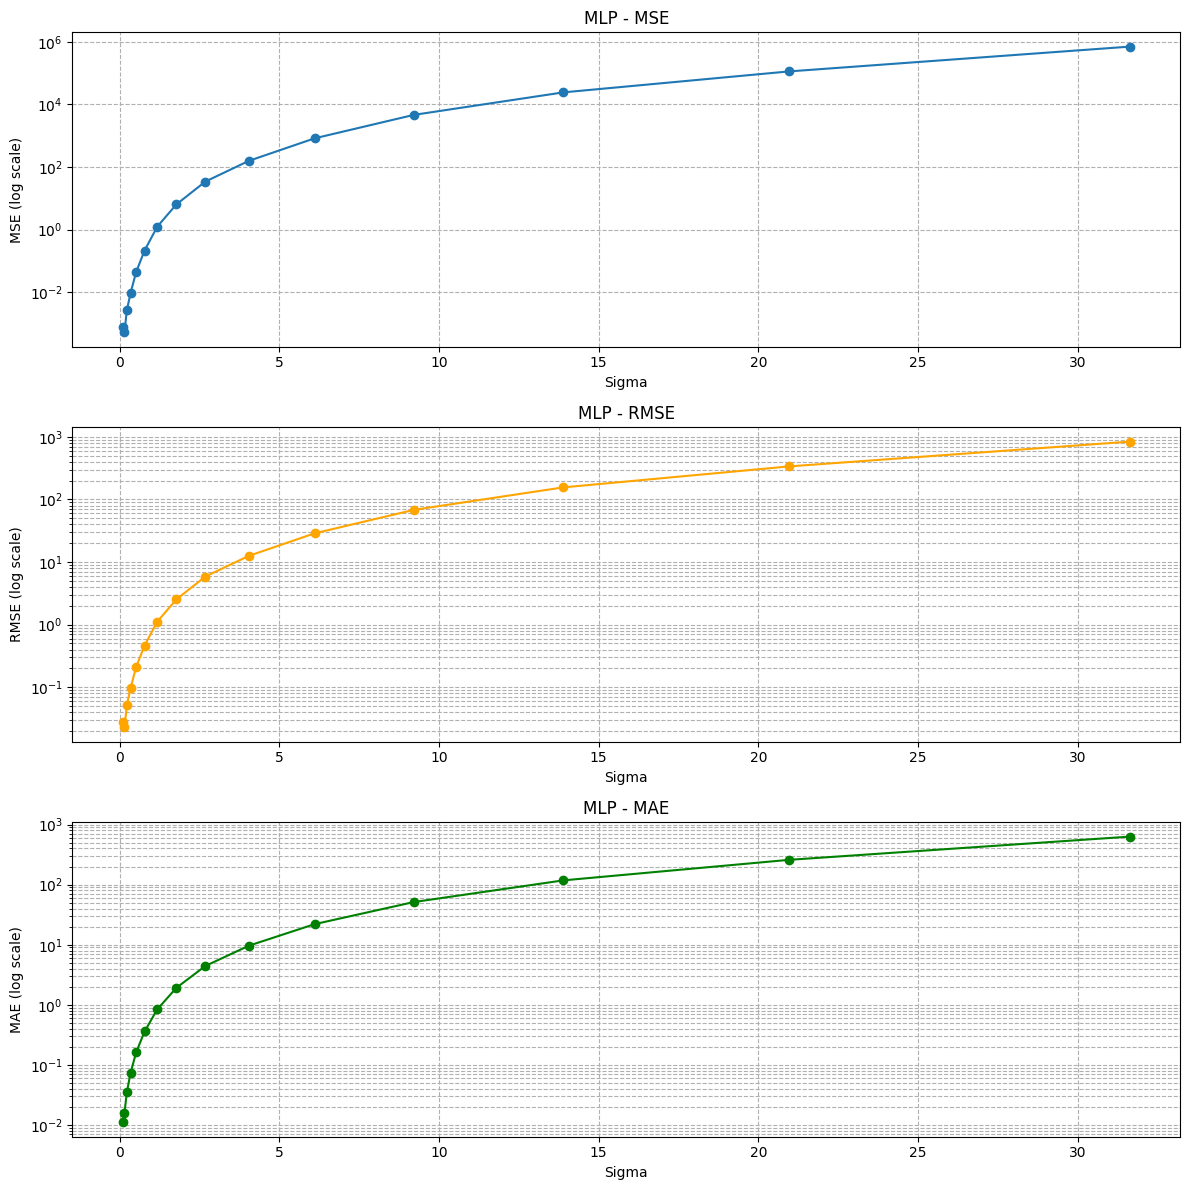

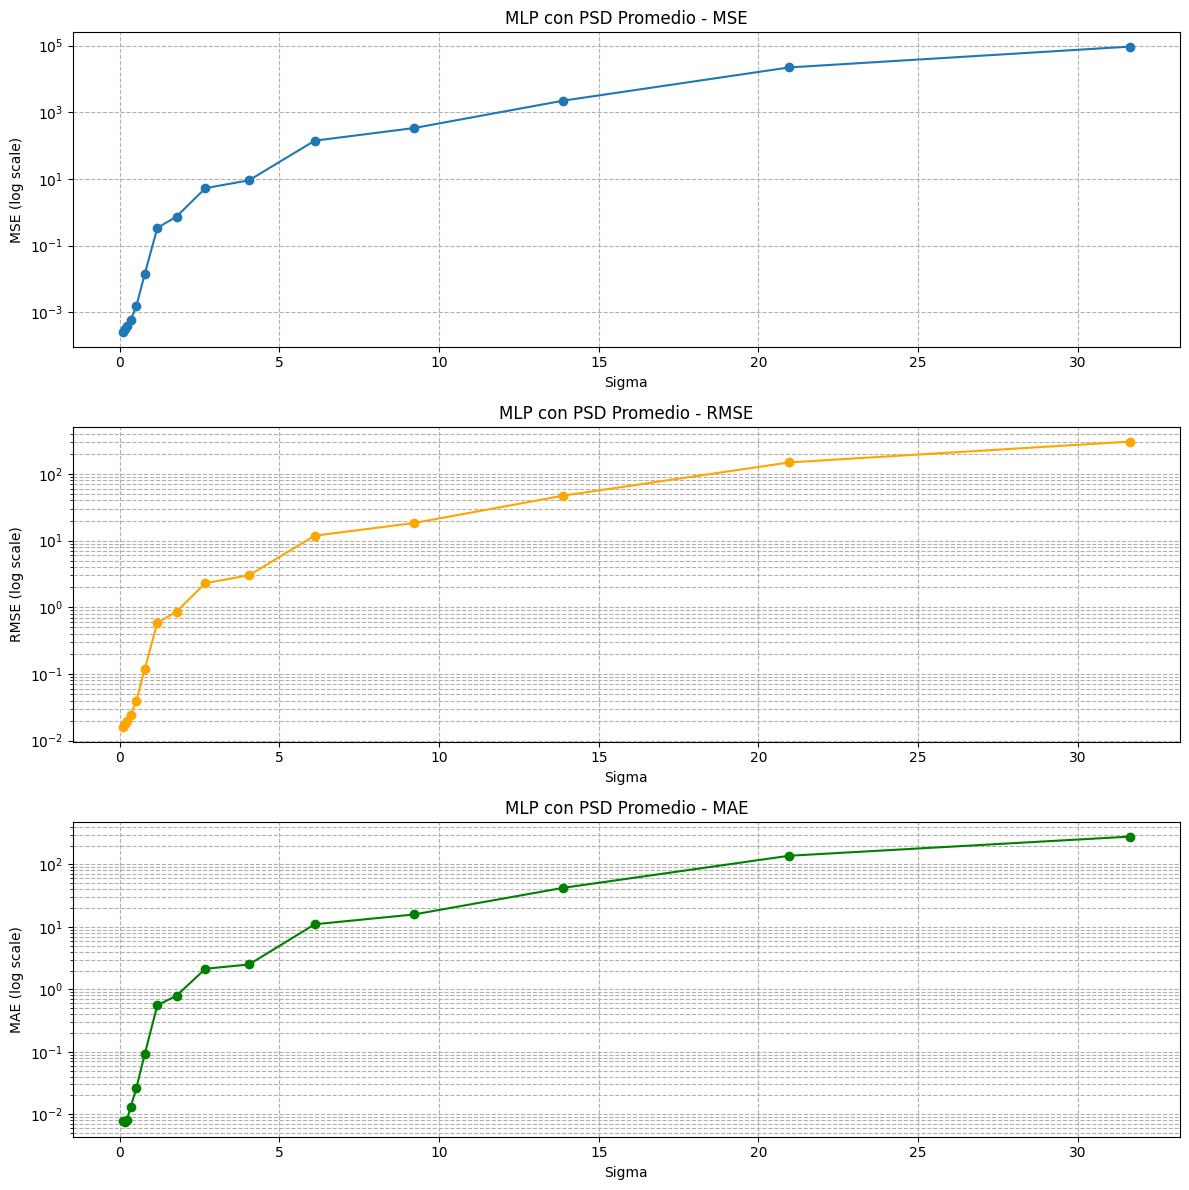

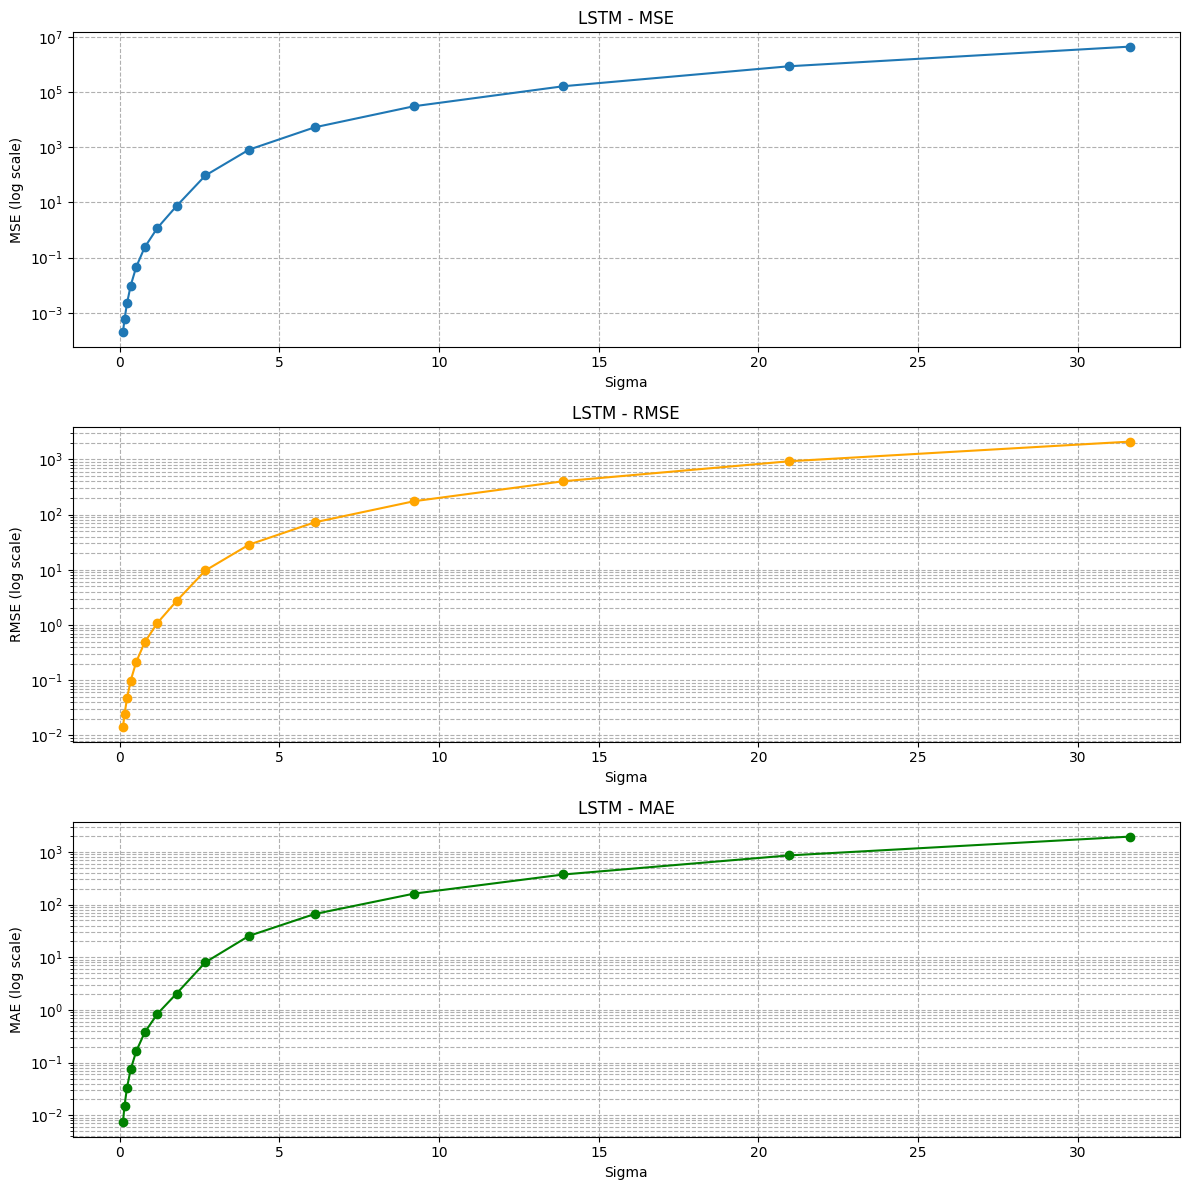

In [14]:
# Graficar métricas para MLP
plot_metrics(df_mlp, 'MLP')

# Graficar métricas para MLP con PSD promedio
plot_metrics(df_mlp_avg, 'MLP con PSD Promedio')

# Graficar métricas para LSTM
plot_metrics(df_lstm, 'LSTM')


: 